In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from GroupingAlgorithm import *
from utils import get_backend_conectivity, RandomHamiltonian
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.algorithms.optimizers import SPSA
from IPython.display import display, clear_output

In this notebook we perform test of the VQE class. First we load our IBM account and define the backends. 

In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_paris')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = AerSimulator(method="statevector") # Backend for simulation
backend_noise = AerSimulator.from_backend(backend_paris)
NUM_SHOTS = 2**13  # Number of shots for each circuit

We create a Hamiltonian to perform the test.

In [3]:
# qubit_op, init_state = LiH(initial_state=True)
# num_qubits = qubit_op.num_qubits

In [4]:
num_qubits = 2
qubit_op = RandomHamiltonian( num_qubits, 6 )
init_state = QuantumCircuit(num_qubits)
print( qubit_op )

SummedOp([
  YX,
  XY,
  XZ,
  IZ,
  II,
  YX
])


We calculate the minimum energy of the Hamiltonian by a classical method.

In [5]:
result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
result_exact.eigenvalue 

(-2.605551275463986+1.52199692136892e-16j)

We will employ a Hardware efficient variation form.

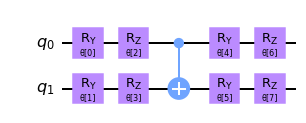

In [6]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

We define a callback function, to have the behavior of the algorithm by iterations.

In [7]:
def callback( evals, params ):  
    display("{}, {}".format(len(evaluations),evals))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []

We select SPSA with 100 iterations as classical optimizer.

In [8]:
optimizer = SPSA( maxiter=100, last_avg=1 )

Initial parameters for the optimization

In [9]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var

In [10]:
result_exact.eigenvalue 

(-2.605551275463986+1.52199692136892e-16j)

VQE with entangled grouping

In [11]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.55859375


VQE with TPB grouping

In [12]:
solver = VQE( ansatz, optimizer, pars, grouping = 'TPB' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.576171875


VQE with entangled grouping and the conectivity of ibm-q paris

In [13]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', conectivity = WC_paris )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.59375


Testing callback function

In [14]:
parameters  = []
evaluations = []
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.580078125


Testing simulation with noise model

In [15]:
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=100, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback, quantum_instance=backend_noise )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.123046875


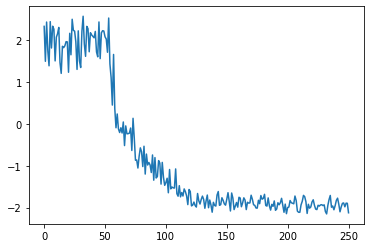

In [16]:
plt.plot( evaluations )

Testing quantum instance

In [17]:
qi = QuantumInstance( backend_sim, shots = NUM_SHOTS )
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=100, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', quantum_instance=qi )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.6005859375


In [18]:
print(results)

OrderedDict([   ('aux_operator_eigenvalues', None),
                ('cost_function_evals', 200),
                (   'eigenstate',
                    {   '00': 0.5201036555341637,
                        '01': 0.32775276505317236,
                        '10': 0.21452390965228096,
                        '11': 0.7589794494500494}),
                ('eigenvalue', -2.6005859375),
                (   'optimal_parameters',
                    {   ParameterVectorElement(θ[0]): -1.2157362816843265,
                        ParameterVectorElement(θ[1]): -3.996616405275558,
                        ParameterVectorElement(θ[2]): 3.188660253054801,
                        ParameterVectorElement(θ[3]): 4.576297885043973,
                        ParameterVectorElement(θ[5]): -0.24486147099982422,
                        ParameterVectorElement(θ[4]): 3.3463286970083255,
                        ParameterVectorElement(θ[6]): 0.15741735268292875,
                        ParameterVectorElement(θ[7]): 1

Testing another function of the VQE class

In [19]:
solver.ansatz

In [20]:
solver.cleanup_parameterized_circuits

<bound method VariationalAlgorithm.cleanup_parameterized_circuits of <VQE.VQE object at 0x0000016ADE28FB48>>

In [21]:
solver.construct_expectation( pars, qubit_op )[0].draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐┌─────┐┌───┐┌─┐
q31248_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├┤ SDG ├┤ H ├┤M├
          ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤└┬───┬┘└┬─┬┘└╥┘
q31248_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├─┤ H ├──┤M├──╫─
          └──────────┘└──────────┘└───┘└──────────┘└──────────┘ └───┘  └╥┘  ║ 
   c36: 1/══════════════════════════════════════════════════════════════╬═══╩═
                                                                        ║   0 
                                                                        ║     
   c37: 1/══════════════════════════════════════════════════════════════╩═════
                                                                        0

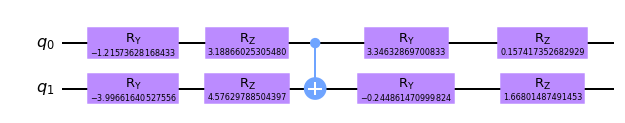

In [22]:
solver.get_optimal_circuit().draw(output='mpl')

In [23]:
solver.get_optimal_cost()

-2.6005859375

In [24]:
solver.get_optimal_vector()

{'11': 0.7589794494500494,
 '01': 0.32886820593514354,
 '10': 0.22480460265528374,
 '00': 0.5150328038702972}

In [25]:
# solver.get_prob_vector_for_params()

In [26]:
# solver.get_probabilities_for_counts()

In [27]:
solver.initial_point

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

In [28]:
solver.optimal_params

array([-1.21573628, -3.99661641,  3.18866025,  4.57629789,  3.3463287 ,
       -0.24486147,  0.15741735,  1.66801487])

In [29]:
solver.optimizer

In [30]:
solver.quantum_instance

In [31]:
solver.supports_aux_operators()

False

In [32]:
print( solver.print_settings() )


==================== Setting of VQE ============================
Algorithm: VQE
-- ansatz_params: [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7])]
-- ansatz:      ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘
-- quantum_instance: 
Qiskit Terra version: 0.17.0
Backend: 'aer_simulator_statevector (None)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcx_gray', 

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table